### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import math

from sklearn.metrics import log_loss, make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedGroupKFold

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

### Data Prep

In [2]:
COMP_PATH = "/kaggle/input/icr-identify-age-related-conditions"
train = pd.read_csv(f"{COMP_PATH}/train.csv")
test = pd.read_csv(f"{COMP_PATH}/test.csv")
sample_submission = pd.read_csv(f"{COMP_PATH}/sample_submission.csv")
greeks = pd.read_csv(f"{COMP_PATH}/greeks.csv")

In [3]:
int_denominators = {
 'AB': 0.004273,
 'AF': 0.00242,
 'AH': 0.008709,
 'AM': 0.003097,
 'AR': 0.005244,
 'AX': 0.008859,
 'AY': 0.000609,
 'AZ': 0.006302,
 'BC': 0.007028,
 'BD ': 0.00799,
 'BN': 0.3531,
 'BP': 0.004239,
 'BQ': 0.002605,
 'BR': 0.006049,
 'BZ': 0.004267,
 'CB': 0.009191,
 'CC': 6.12e-06,
 'CD ': 0.007928,
 'CF': 0.003041,
 'CH': 0.000398,
 'CL': 0.006365,
 'CR': 7.5e-05,
 'CS': 0.003487,
 'CU': 0.005517,
 'CW ': 9.2e-05,
 'DA': 0.00388,
 'DE': 0.004435,
 'DF': 0.000351,
 'DH': 0.002733,
 'DI': 0.003765,
 'DL': 0.00212,
 'DN': 0.003412,
 'DU': 0.0013794,
 'DV': 0.00259,
 'DY': 0.004492,
 'EB': 0.007068,
 'EE': 0.004031,
 'EG': 0.006025,
 'EH': 0.006084,
 'EL': 0.000429,
 'EP': 0.009269,
 'EU': 0.005064,
 'FC': 0.005712,
 'FD ': 0.005937,
 'FE': 0.007486,
 'FI': 0.005513,
 'FR': 0.00058,
 'FS': 0.006773,
 'GB': 0.009302,
 'GE': 0.004417,
 'GF': 0.004374,
 'GH': 0.003721,
 'GI': 0.002572
}
def to_int(df):
    for k, v in int_denominators.items():
        df[k] = np.round(df[k]/v,1)
    return df

In [4]:
# FL, GLはfloat 
train = to_int(train.copy())
test = to_int(test.copy())

train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,49.0,1284724.5,9783.0,7231.0,1552.0,79.0,42.0,1557.0,790.5,...,7.298162,2997.5,14.0,1219.0,16439.0,458118.5,5949.0,27152.0,0.120343,1
1,007255e47698,34.0,404448.0,9783.0,11937.0,1552.0,410.0,42.0,2145.0,175.0,...,0.173229,857.0,84.0,999.0,16439.0,6397248.0,7830.0,12493.0,21.978000,0
2,013f2bd269f5,110.0,1088887.0,9783.0,10449.0,1552.0,760.0,42.0,2035.0,175.0,...,7.709560,1682.0,177.0,3986.0,20061.0,3126876.5,7531.0,13683.0,0.196941,0
3,043ac50845d5,59.0,1578368.5,13802.0,24899.0,1552.0,416.0,42.0,1754.0,175.0,...,6.122162,857.0,42.0,1992.0,18659.0,478798.0,10736.0,35184.0,0.155829,0
4,044fb8a146ec,89.0,1542582.0,9783.0,4554.0,1552.0,445.0,90.0,539.0,14535.0,...,8.153058,83623.0,18.0,1764.0,33079.0,1948873.0,12196.0,14099.0,0.096614,1


In [5]:
train.fillna(train.median(), inplace=True)
test.fillna(test.median(), inplace=True)

In [6]:
cols = train.columns
feat_cols = cols[1:]
num_cols = train.select_dtypes(include=['float64']).columns
print("No of Columns:", len(cols))

No of Columns: 58


### Metric

In [7]:
def competition_log_loss(y_true, y_pred):
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0)) / N_0
    log_loss_1 = -np.sum(y_true * np.log(p_1)) / N_1
    return (log_loss_0 + log_loss_1)/2

def balanced_log_loss(y_true, y_pred):
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    return balanced_log_loss/(N_0+N_1)

In [8]:
def lgb_metric(y_true, y_pred):
    return 'balanced_log_loss', balanced_log_loss(y_true, y_pred), False

### Feature Engineering

In [9]:
# Label encoding
train['EJ'] = train['EJ'].map({'A': 0, 'B': 1})
test['EJ']  = test['EJ'].map({'A': 0, 'B': 1})

In [10]:
scaler = StandardScaler()
df, test_df = train.copy(), test.copy()
new_num_cols = train.select_dtypes(include=['float64']).columns
df[new_num_cols] = scaler.fit_transform(train[new_num_cols])
test_df[new_num_cols] = scaler.transform(test[new_num_cols])
df

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,-0.572153,-0.170975,-0.261669,-0.237889,-0.189295,-1.900558,-0.083417,-0.173502,-0.038354,...,0.162821,-0.035806,-0.250437,-0.940094,-0.410260,-0.655511,-0.948991,0.531241,-0.814049,1
1,007255e47698,-0.709105,-1.097801,-0.261669,-0.028701,-0.189295,-0.750457,-0.083417,0.678919,-0.104787,...,-0.457925,-0.060566,0.113640,-1.145070,-0.410260,0.687893,-0.238862,-0.509218,1.304860,0
2,013f2bd269f5,-0.015212,-0.377169,-0.261669,-0.094845,-0.189295,0.465662,-0.083417,0.519453,-0.104787,...,0.198663,-0.051023,0.597343,1.637944,-0.299210,-0.051850,-0.351743,-0.424754,-0.806623,0
3,043ac50845d5,-0.480851,0.138196,0.012347,0.547477,-0.189295,-0.729610,-0.083417,0.112088,-0.104787,...,0.060364,-0.060566,-0.104806,-0.219883,-0.342195,-0.650833,0.858232,1.101332,-0.810609,0
4,044fb8a146ec,-0.206946,0.100517,-0.261669,-0.356885,-0.189295,-0.628845,-0.013229,-1.649292,1.445139,...,0.237302,0.896815,-0.229632,-0.432313,0.099920,-0.318309,1.409422,-0.395228,-0.816349,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,-0.699975,-0.161828,0.040232,-0.422762,0.275215,-0.802577,0.040875,-0.464891,-0.080610,...,-0.457925,-0.045332,-0.271241,-1.177680,0.593022,-0.340465,-0.694915,0.513497,1.304860,0
613,fd895603f071,-0.088253,0.852755,-0.261669,0.108831,0.556117,0.170319,-0.082686,0.473063,-0.065661,...,0.417655,-0.045702,0.004417,1.519617,2.535523,-0.599582,-0.186764,2.048314,-0.811625,0
614,fd8ef6377f76,-0.106514,-0.453742,0.090140,0.235206,-0.011673,0.990330,-0.083417,1.113828,-0.104787,...,-0.457925,-0.060566,-0.271241,-0.076400,-0.019561,-0.424307,-0.540129,1.903449,1.304860,0
615,fe1942975e40,-0.243466,-0.973904,-0.261669,-0.219353,-0.189295,0.955584,-0.083417,-0.699741,-0.104787,...,0.333481,-0.054771,0.191657,0.387591,-0.410260,-0.657500,-0.646592,-0.370599,-0.807817,0


### Multilabel Stratification

In [11]:
# https://github.com/trent-b/iterative-stratification
# I copied it from the above github.
import numpy as np
from sklearn.utils import check_random_state
from sklearn.utils.validation import _num_samples, check_array
from sklearn.utils.multiclass import type_of_target
from sklearn.model_selection._split import _BaseKFold, _RepeatedSplits, \
    BaseShuffleSplit, _validate_shuffle_split

def IterativeStratification(labels, r, random_state):
    """This function implements the Iterative Stratification algorithm described
    in the following paper:
    Sechidis K., Tsoumakas G., Vlahavas I. (2011) On the Stratification of
    Multi-Label Data. In: Gunopulos D., Hofmann T., Malerba D., Vazirgiannis M.
    (eds) Machine Learning and Knowledge Discovery in Databases. ECML PKDD
    2011. Lecture Notes in Computer Science, vol 6913. Springer, Berlin,
    Heidelberg.
    """

    n_samples = labels.shape[0]
    test_folds = np.zeros(n_samples, dtype=int)

    # Calculate the desired number of examples at each subset
    c_folds = r * n_samples

    # Calculate the desired number of examples of each label at each subset
    c_folds_labels = np.outer(r, labels.sum(axis=0))

    labels_not_processed_mask = np.ones(n_samples, dtype=bool)

    while np.any(labels_not_processed_mask):
        # Find the label with the fewest (but at least one) remaining examples,
        # breaking ties randomly
        num_labels = labels[labels_not_processed_mask].sum(axis=0)

        # Handle case where only all-zero labels are left by distributing
        # across all folds as evenly as possible (not in original algorithm but
        # mentioned in the text). (By handling this case separately, some
        # code redundancy is introduced; however, this approach allows for
        # decreased execution time when there are a relatively large number
        # of all-zero labels.)
        if num_labels.sum() == 0:
            sample_idxs = np.where(labels_not_processed_mask)[0]

            for sample_idx in sample_idxs:
                fold_idx = np.where(c_folds == c_folds.max())[0]

                if fold_idx.shape[0] > 1:
                    fold_idx = fold_idx[random_state.choice(fold_idx.shape[0])]

                test_folds[sample_idx] = fold_idx
                c_folds[fold_idx] -= 1

            break

        label_idx = np.where(num_labels == num_labels[np.nonzero(num_labels)].min())[0]
        if label_idx.shape[0] > 1:
            label_idx = label_idx[random_state.choice(label_idx.shape[0])]

        sample_idxs = np.where(np.logical_and(labels[:, label_idx].flatten(), labels_not_processed_mask))[0]

        for sample_idx in sample_idxs:
            # Find the subset(s) with the largest number of desired examples
            # for this label, breaking ties by considering the largest number
            # of desired examples, breaking further ties randomly
            label_folds = c_folds_labels[:, label_idx]
            fold_idx = np.where(label_folds == label_folds.max())[0]

            if fold_idx.shape[0] > 1:
                temp_fold_idx = np.where(c_folds[fold_idx] ==
                                         c_folds[fold_idx].max())[0]
                fold_idx = fold_idx[temp_fold_idx]

                if temp_fold_idx.shape[0] > 1:
                    fold_idx = fold_idx[random_state.choice(temp_fold_idx.shape[0])]

            test_folds[sample_idx] = fold_idx
            labels_not_processed_mask[sample_idx] = False

            # Update desired number of examples
            c_folds_labels[fold_idx, labels[sample_idx]] -= 1
            c_folds[fold_idx] -= 1

    return test_folds

class MultilabelStratifiedKFold(_BaseKFold):
    """Multilabel stratified K-Folds cross-validator
    Provides train/test indices to split multilabel data into train/test sets.
    This cross-validation object is a variation of KFold that returns
    stratified folds for multilabel data. The folds are made by preserving
    the percentage of samples for each label.
    Parameters
    ----------
    n_splits : int, default=3
        Number of folds. Must be at least 2.
    shuffle : boolean, optional
        Whether to shuffle each stratification of the data before splitting
        into batches.
    random_state : int, RandomState instance or None, optional, default=None
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`. Unlike StratifiedKFold that only uses random_state
        when ``shuffle`` == True, this multilabel implementation
        always uses the random_state since the iterative stratification
        algorithm breaks ties randomly.
    Examples
    --------
    >>> from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
    >>> import numpy as np
    >>> X = np.array([[1,2], [3,4], [1,2], [3,4], [1,2], [3,4], [1,2], [3,4]])
    >>> y = np.array([[0,0], [0,0], [0,1], [0,1], [1,1], [1,1], [1,0], [1,0]])
    >>> mskf = MultilabelStratifiedKFold(n_splits=2, random_state=0)
    >>> mskf.get_n_splits(X, y)
    2
    >>> print(mskf)  # doctest: +NORMALIZE_WHITESPACE
    MultilabelStratifiedKFold(n_splits=2, random_state=0, shuffle=False)
    >>> for train_index, test_index in mskf.split(X, y):
    ...    print("TRAIN:", train_index, "TEST:", test_index)
    ...    X_train, X_test = X[train_index], X[test_index]
    ...    y_train, y_test = y[train_index], y[test_index]
    TRAIN: [0 3 4 6] TEST: [1 2 5 7]
    TRAIN: [1 2 5 7] TEST: [0 3 4 6]
    Notes
    -----
    Train and test sizes may be slightly different in each fold.
    See also
    --------
    RepeatedMultilabelStratifiedKFold: Repeats Multilabel Stratified K-Fold
    n times.
    """

    def __init__(self, n_splits=3, *, shuffle=False, random_state=None):
        super(MultilabelStratifiedKFold, self).__init__(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    def _make_test_folds(self, X, y):
        y = np.asarray(y, dtype=bool)
        type_of_target_y = type_of_target(y)

        if type_of_target_y != 'multilabel-indicator':
            raise ValueError(
                'Supported target type is: multilabel-indicator. Got {!r} instead.'.format(type_of_target_y))

        num_samples = y.shape[0]

        rng = check_random_state(self.random_state)
        indices = np.arange(num_samples)

        if self.shuffle:
            rng.shuffle(indices)
            y = y[indices]

        r = np.asarray([1 / self.n_splits] * self.n_splits)

        test_folds = IterativeStratification(labels=y, r=r, random_state=rng)

        return test_folds[np.argsort(indices)]

    def _iter_test_masks(self, X=None, y=None, groups=None):
        test_folds = self._make_test_folds(X, y)
        for i in range(self.n_splits):
            yield test_folds == i

    def split(self, X, y, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
            Note that providing ``y`` is sufficient to generate the splits and
            hence ``np.zeros(n_samples)`` may be used as a placeholder for
            ``X`` instead of actual training data.
        y : array-like, shape (n_samples, n_labels)
            The target variable for supervised learning problems.
            Multilabel stratification is done based on the y labels.
        groups : object
            Always ignored, exists for compatibility.
        Returns
        -------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        Notes
        -----
        Randomized CV splitters may return different results for each call of
        split. You can make the results identical by setting ``random_state``
        to an integer.
        """
        y = check_array(y, ensure_2d=False, dtype=None)
        return super(MultilabelStratifiedKFold, self).split(X, y, groups)

class RepeatedMultilabelStratifiedKFold(_RepeatedSplits):
    """Repeated Multilabel Stratified K-Fold cross validator.
    Repeats Mulilabel Stratified K-Fold n times with different randomization
    in each repetition.
    Parameters
    ----------
    n_splits : int, default=5
        Number of folds. Must be at least 2.
    n_repeats : int, default=10
        Number of times cross-validator needs to be repeated.
    random_state : None, int or RandomState, default=None
        Random state to be used to generate random state for each
        repetition as well as randomly breaking ties within the iterative
        stratification algorithm.
    Examples
    --------
    >>> from iterstrat.ml_stratifiers import RepeatedMultilabelStratifiedKFold
    >>> import numpy as np
    >>> X = np.array([[1,2], [3,4], [1,2], [3,4], [1,2], [3,4], [1,2], [3,4]])
    >>> y = np.array([[0,0], [0,0], [0,1], [0,1], [1,1], [1,1], [1,0], [1,0]])
    >>> rmskf = RepeatedMultilabelStratifiedKFold(n_splits=2, n_repeats=2,
    ...     random_state=0)
    >>> for train_index, test_index in rmskf.split(X, y):
    ...     print("TRAIN:", train_index, "TEST:", test_index)
    ...     X_train, X_test = X[train_index], X[test_index]
    ...     y_train, y_test = y[train_index], y[test_index]
    ...
    TRAIN: [0 3 4 6] TEST: [1 2 5 7]
    TRAIN: [1 2 5 7] TEST: [0 3 4 6]
    TRAIN: [0 1 4 5] TEST: [2 3 6 7]
    TRAIN: [2 3 6 7] TEST: [0 1 4 5]
    See also
    --------
    RepeatedStratifiedKFold: Repeats (Non-multilabel) Stratified K-Fold
    n times.
    """
    def __init__(self, n_splits=5, *, n_repeats=10, random_state=None):
        super(RepeatedMultilabelStratifiedKFold, self).__init__(
            MultilabelStratifiedKFold, n_repeats=n_repeats, random_state=random_state,
            n_splits=n_splits)

class MultilabelStratifiedShuffleSplit(BaseShuffleSplit):
    """Multilabel Stratified ShuffleSplit cross-validator
    Provides train/test indices to split data into train/test sets.
    This cross-validation object is a merge of MultilabelStratifiedKFold and
    ShuffleSplit, which returns stratified randomized folds for multilabel
    data. The folds are made by preserving the percentage of each label.
    Note: like the ShuffleSplit strategy, multilabel stratified random splits
    do not guarantee that all folds will be different, although this is
    still very likely for sizeable datasets.
    Parameters
    ----------
    n_splits : int, default 10
        Number of re-shuffling & splitting iterations.
    test_size : float, int, None, optional
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to the
        complement of the train size. By default, the value is set to 0.1.
        The default will change in version 0.21. It will remain 0.1 only
        if ``train_size`` is unspecified, otherwise it will complement
        the specified ``train_size``.
    train_size : float, int, or None, default is None
        If float, should be between 0.0 and 1.0 and represent the
        proportion of the dataset to include in the train split. If
        int, represents the absolute number of train samples. If None,
        the value is automatically set to the complement of the test size.
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`. Unlike StratifiedShuffleSplit that only uses
        random_state when ``shuffle`` == True, this multilabel implementation
        always uses the random_state since the iterative stratification
        algorithm breaks ties randomly.
    Examples
    --------
    >>> from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
    >>> import numpy as np
    >>> X = np.array([[1,2], [3,4], [1,2], [3,4], [1,2], [3,4], [1,2], [3,4]])
    >>> y = np.array([[0,0], [0,0], [0,1], [0,1], [1,1], [1,1], [1,0], [1,0]])
    >>> msss = MultilabelStratifiedShuffleSplit(n_splits=3, test_size=0.5,
    ...    random_state=0)
    >>> msss.get_n_splits(X, y)
    3
    >>> print(mss)       # doctest: +ELLIPSIS
    MultilabelStratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.5,
                                     train_size=None)
    >>> for train_index, test_index in msss.split(X, y):
    ...    print("TRAIN:", train_index, "TEST:", test_index)
    ...    X_train, X_test = X[train_index], X[test_index]
    ...    y_train, y_test = y[train_index], y[test_index]
    TRAIN: [1 2 5 7] TEST: [0 3 4 6]
    TRAIN: [2 3 6 7] TEST: [0 1 4 5]
    TRAIN: [1 2 5 6] TEST: [0 3 4 7]
    Notes
    -----
    Train and test sizes may be slightly different from desired due to the
    preference of stratification over perfectly sized folds.
    """
    def __init__(self, n_splits=10, *, test_size="default", train_size=None,
                 random_state=None):
        super(MultilabelStratifiedShuffleSplit, self).__init__(
            n_splits=n_splits, test_size=test_size, train_size=train_size, random_state=random_state)

    def _iter_indices(self, X, y, groups=None):
        n_samples = _num_samples(X)
        y = check_array(y, ensure_2d=False, dtype=None)
        y = np.asarray(y, dtype=bool)
        type_of_target_y = type_of_target(y)

        if type_of_target_y != 'multilabel-indicator':
            raise ValueError(
                'Supported target type is: multilabel-indicator. Got {!r} instead.'.format(
                    type_of_target_y))

        n_train, n_test = _validate_shuffle_split(n_samples, self.test_size,
                                                  self.train_size)

        n_samples = y.shape[0]
        rng = check_random_state(self.random_state)
        y_orig = y.copy()

        r = np.array([n_train, n_test]) / (n_train + n_test)

        for _ in range(self.n_splits):
            indices = np.arange(n_samples)
            rng.shuffle(indices)
            y = y_orig[indices]

            test_folds = IterativeStratification(labels=y, r=r, random_state=rng)

            test_idx = test_folds[np.argsort(indices)] == 1
            test = np.where(test_idx)[0]
            train = np.where(~test_idx)[0]

            yield train, test

    def split(self, X, y, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
            Note that providing ``y`` is sufficient to generate the splits and
            hence ``np.zeros(n_samples)`` may be used as a placeholder for
            ``X`` instead of actual training data.
        y : array-like, shape (n_samples, n_labels)
            The target variable for supervised learning problems.
            Multilabel stratification is done based on the y labels.
        groups : object
            Always ignored, exists for compatibility.
        Returns
        -------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        Notes
        -----
        Randomized CV splitters may return different results for each call of
        split. You can make the results identical by setting ``random_state``
        to an integer.
        """
        y = check_array(y, ensure_2d=False, dtype=None)
        return super(MultilabelStratifiedShuffleSplit, self).split(X, y, groups)

### CV

In [12]:
kf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
df['fold'] = -1

for fold, (train_idx, test_idx) in enumerate(kf.split(X=train, y=greeks.iloc[:,1:3])):
    df.loc[test_idx, 'fold'] = fold

df.groupby('fold')["Class"].value_counts()

fold  Class
0     0        101
      1         22
1     0        106
      1         17
2     0        102
      1         22
3     0        102
      1         21
4     0         98
      1         26
Name: Class, dtype: int64

### Training

In [23]:
metric = balanced_log_loss
final_valid_predictions = {}
final_test_predictions = []
scores = []
log_losses = []
balanced_log_losses = []
weights = []
outer_cv_score = [] # store all cv scores of outer loop inference
inner_cv_score = [] # store all cv scores of inner loop training
models = []

for fold in range(5):
    train_df = df[df['fold'] != fold]
    valid_df = df[df['fold'] == fold]
    valid_ids = valid_df.Id.values.tolist()

    X_train, y_train = train_df.drop(['Id', 'Class', 'fold'], axis=1), train_df['Class']
    X_valid, y_valid = valid_df.drop(['Id', 'Class', 'fold'], axis=1), valid_df['Class']
    
    lgb = LGBMClassifier(boosting_type='goss', learning_rate=0.06733232950390658, n_estimators = 50000, 
                         early_stopping_round = 300, random_state=42,
                        subsample=0.6970532011679706,
                        colsample_bytree=0.6055755840633003,
                         class_weight='balanced',
                         metric='none', is_unbalance=True, max_depth=8)
    
    # 20% hold-out set
    holdout = pd.concat([X_valid,y_valid], axis = 1)
    
    # Create an oof array for inner loop
    oof_inner = np.zeros(len(X_train))
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    models_ = []
    
    print(f"Outer Loop fold {fold}, Inner Loop Training with {X_train.shape[0]} samples, {X_train.shape[1]} features")
    for fold, (fit_idx, val_idx) in enumerate(cv.split(X=X_train, y=y_train)):
        X_fit = X_train.iloc[fit_idx]
        X_val = X_train.iloc[val_idx]
        y_fit = y_train.iloc[fit_idx]
        y_val = y_train.iloc[val_idx]
        
        model = lgb.fit(X_fit, y_fit, eval_set=(X_valid, y_valid), verbose=0,
            eval_metric=lgb_metric)
        models_.append(model)
        val_preds = model.predict(X_val)
        oof_inner[val_idx] = val_preds
        val_score = balanced_log_loss(y_val, val_preds)
        best_iter = model.booster_.best_iteration
        print(f'Fold: {fold:>3}| {metric.__name__}: {val_score:.5f}'
              f' | Best iteration: {best_iter:>4}')
        
    mean_cv_score = metric(y_train, oof_inner)
    print(f'80% data CV score: {metric.__name__}: {mean_cv_score:.5f}')
    print(f'{"*" * 50}\n')
    inner_cv_score.append(mean_cv_score)
    
    # infer 20% data using 5-fold model trained in inner loop
    preds = np.zeros(len(holdout))
    for model in models_:
        preds += model.predict(X_valid)
    preds = preds / len(models_)
    cv_score = metric(y_valid, preds)
    print(f'20% data CV score: {metric.__name__}: {cv_score:.5f}')
    print(f'{"*" * 50}\n')
    outer_cv_score.append(cv_score)
    models.append(models_)
print(f'80% data average CV score: {metric.__name__}: {np.mean(inner_cv_score):.5f}')
print(f'{"*" * 50}\n')

print(f'20% data average CV score: {metric.__name__}: {np.mean(outer_cv_score):.5f}')
print(f'{"*" * 50}\n')

Outer Loop fold 0, Inner Loop Training with 494 samples, 56 features
Fold:   0| balanced_log_loss: 2.41045 | Best iteration:   67
Fold:   1| balanced_log_loss: 2.03692 | Best iteration:   65
Fold:   2| balanced_log_loss: 3.43243 | Best iteration:   70
Fold:   3| balanced_log_loss: 0.83873 | Best iteration:   97
Fold:   4| balanced_log_loss: 1.92764 | Best iteration:   70
80% data CV score: balanced_log_loss: 2.13546
**************************************************

20% data CV score: balanced_log_loss: 1.98618
**************************************************

Outer Loop fold 1, Inner Loop Training with 494 samples, 56 features
Fold:   0| balanced_log_loss: 1.93117 | Best iteration:  117
Fold:   1| balanced_log_loss: 1.45896 | Best iteration:  253
Fold:   2| balanced_log_loss: 3.17163 | Best iteration:  167
Fold:   3| balanced_log_loss: 1.58583 | Best iteration:  161
Fold:   4| balanced_log_loss: 1.48169 | Best iteration:  199
80% data CV score: balanced_log_loss: 1.92825
**********

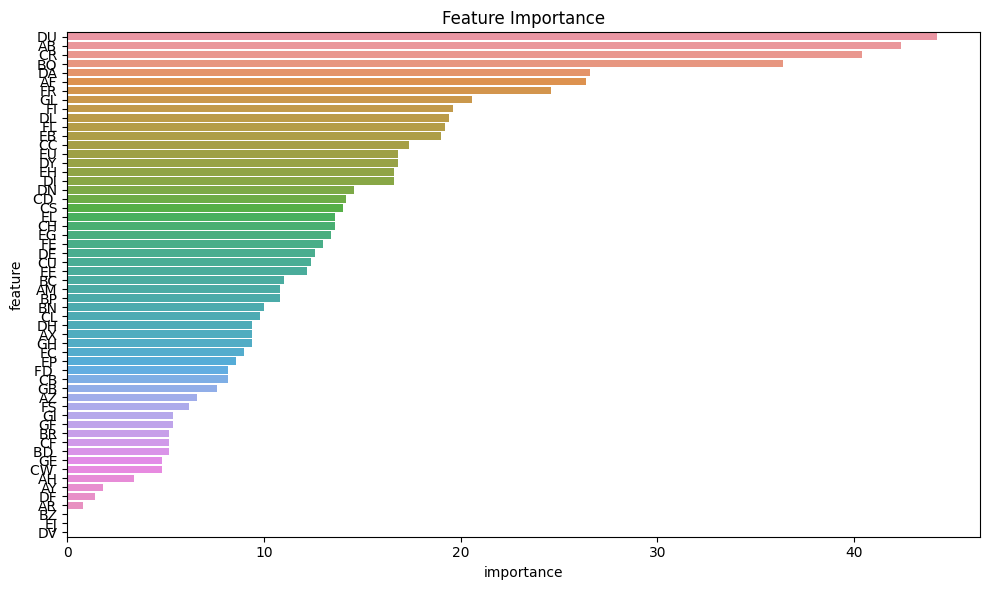

In [32]:
def plot_feature_importance(models, feature_names):
    # Initialize array of importances
    importances = np.zeros(len(feature_names))

    # For each model, add the feature importances
    for model_list in models:
        for model in model_list:
            importances += model.feature_importances_

    # Average the importances over all models
    importances /= sum([len(models_) for models_ in models])

    # Create a DataFrame of feature importances for easy plotting
    importances_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importances_df)
    plt.title('Feature Importance')
    plt.tight_layout()

plot_feature_importance(models, feat_cols[:-1])

In [33]:
feat_cols

Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL',
       'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'],
      dtype='object')